# Regularized Linear Regression and Bias versus Variance
In this exercise, you will implement regularized linear regression and use it to
study models with different bias-variance properties.

## Regularized Linear Regression
In the first half of the exercise, we implement regularized linear regression to predict the amount of water flowing out of a dam using the change of water level in a reservoir. 
In the next half, we go through some diagnostics of debugging learning algorithms and examine the effects of bias versus variance.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
plt.style.use('ggplot')

### Visualizing the dataset
We will begin by visualizing the dataset containing historical records on the change in the water level, x, and the amount of water flowing out of the dam, y.
This dataset is divided into three parts:
- A training set that your model will learn on: X, y
- A cross validation set for determining the regularization parameter:
Xval, yval
- A test set for evaluating performance. These are “unseen” examples
which your model did not see during training: Xtest, ytest

We import the data, and then plot the training data. In the
following parts, we implement linear regression and use that to fit a
straight line to the data and plot learning curves. Following that, we
implement polynomial regression to find a better fit to the data.


In [3]:
data = scipy.io.loadmat('./data/ex5data1.mat')
X, y = data['X'], data['y'].T[0]
Xtest, ytest = data['Xtest'], data['ytest'].T[0]
Xval, yval = data['Xval'], data['yval'].T[0]

((12, 1), (12,))

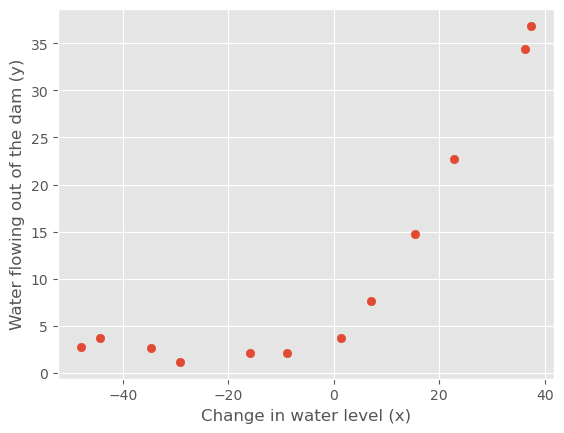

In [4]:
plt.scatter(X, y)
plt.xlabel('Change in water level (x)')
plt.ylabel('Water flowing out of the dam (y)')
X.shape, y.shape

### Regularized linear regression cost function

Recall that regularized linear regression has the following cost function:

$$
J(\theta) = \frac{1}{2m} \sum_{i=1}^{m} \left( h_{\theta}(x^{(i)}) - y^{(i)} \right)^2 + \frac{\lambda}{2m} \sum_{j=1}^{n} \theta_{j}^2,
$$

where $ \lambda $ is a regularization parameter which controls the degree of regularization (thus, helping to prevent overfitting). The regularization term puts a penalty on the overall cost $ J $. As the magnitudes of the model parameters $ \theta_j $ increase, the penalty increases as well. Note that you should not regularize the $ \theta_0 $ term.

Wr now complete the code in `linearRegCostFunction`. Your write a function to calculate the regularized linear regression cost function. We try to vectorize your code and avoid writing loops. We run the cost function using `theta` initialized at `[1; 1]`. We should expect to see an output of 303.993.


In [5]:
def hypothesis(X, theta):
    theta = np.array(theta)
    X = np.hstack((np.ones((X.shape[0], 1)), X))
    return X @ theta

hypothesis(X, [1, 1])

array([-14.93675813, -28.15297922,  37.18954863,  38.49218733,
       -47.05882945,  -7.94145794,  16.30779289, -33.70626581,
         2.38915437, -43.38375985,   8.01350208,  23.76274892])

In [6]:
def cost(X, y, mu=0):
    m = len(y)
    X = np.hstack((np.ones((X.shape[0], 1)), X))
    def J(theta):
        theta = np.array(theta)
        h = X @ theta
        term1 = np.sum((h - y)**2)
        term2 = mu * np.sum(theta[1:])
        return (term1 + term2) / (2*m)
    return J

cost(X, y)([1, 1])

303.9515255535976

### Regularized linear regression gradient

Correspondingly, the partial derivative of regularized linear regression’s cost for $ \theta_j $ is defined as:

$$
\frac{\partial J(\theta)}{\partial \theta_0} = \frac{1}{m} \sum_{i=1}^{m} (h_{\theta}(x^{(i)}) - y^{(i)})x^{(i)}_j \quad \text{for } j = 0
$$

$$
\frac{\partial J(\theta)}{\partial \theta_j} = \frac{1}{m} \sum_{i=1}^{m} (h_{\theta}(x^{(i)}) - y^{(i)})x^{(i)}_j + \frac{\lambda}{m} \theta_j \quad \text{for } j \geq 1
$$

We create `gradient` to calculate the gradient. When you are finished, we run the gradient function using `theta` initialized at $[1; 1]$. We should expect to see a gradient of $[-15.30; 598.250]$.


In [7]:
def gradient(X, y, mu=0):
    m = len(y)
    X = np.hstack((np.ones((X.shape[0], 1)), X))
    def G(theta):
        theta = np.array(theta)
        h = X @ theta
        grads = []
        for j in range(len(theta)):
            grads_unreg = np.sum((h - y) * X[:, j]) / m
            if j == 0: grads.append(grads_unreg)
            else: grads.append(grads_unreg + mu*theta[j]/m)
        return np.array(grads)
    return G

gradient(X, y)([1, 1])

array([-15.30301567, 598.16741084])

### Fitting linear regression
We now run the code in `trainLinearReg` to compute the optimal value of $\theta$. This training function uses `scipy.optimize.minimize` to optimize the cost function.

In this part, we set the regularization parameter $\lambda$ to zero. Because our current implementation of linear regression is trying to fit a 2-dimensional $\theta$, regularization will not be incredibly helpful for a $\theta$ of such low dimension. In the later parts of the exercise, you will be using polynomial regression with regularization.

Finally, we should also plot the best fit line. 
The best fit line tells us that the model is not a good fit to the data because the data has a non-linear pattern. 
While visualizing the best fit as shown is one possible way to debug the learning algorithm, it is not always easy to visualize the data and model. 
In the next section, we will implement a function to generate learning curves that can help debug the learning algorithm even if it is not easy to visualize the data.


In [8]:
def trainLinearRegression(X, y, theta0=None, mu=0):
    theta = np.zeros(X.shape[1]+1) if theta0 is None else theta0
    J = cost(X, y, mu)
    G = gradient(X, y, mu)
    result = scipy.optimize.minimize(fun=J, jac=G, x0=theta, method='BFGS')
    return result

In [9]:
model = trainLinearRegression(X, y)
theta = model.x
theta

array([13.08790351,  0.36777923])

In [10]:
y_hat = hypothesis(X, theta)

((12, 1), (12,))

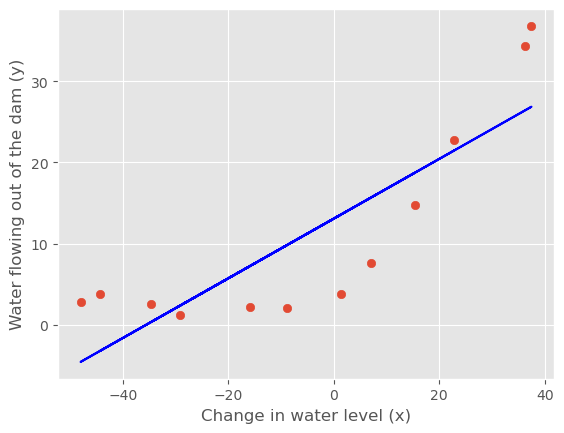

In [11]:
plt.scatter(X, y)
plt.plot(X, y_hat, color='blue')
plt.xlabel('Change in water level (x)')
plt.ylabel('Water flowing out of the dam (y)')
X.shape, y.shape

## Bias-variance

An important concept in machine learning is the bias-variance tradeoff. 
Models with high bias are not complex enough for the data and tend to underfit, 
while models with high variance overfit to the training data. In this part of the exercise, 
we will plot training and test errors on a learning curve to diagnose bias-variance problems.

### Learning curves

We will now implement code to generate the learning curves that will be useful in debugging learning algorithms. 
Recall that a learning curve plots training and cross validation error as a function of training set size. 
Your job is to fill in `learningCurve` so that it returns a vector of errors for the training set and cross validation set.

To plot the learning curve, we need a training and cross validation set error for different training set sizes. To obtain different training set sizes, you should use different subsets of the original training set $ X $. Specifically, for a training set size of $ i $, you should use the first $ i $ examples (i.e., $ X(1:i,:) $ and $ y(1:i) $).

You can use the `trainLinearReg` function to find the $ \theta $ parameters. Note that the lambda $ \lambda $ is passed as a parameter to the `learningCurve` function. After learning the $ \theta $ parameters, you should compute the error on the training and cross validation sets. Recall that the training error for a dataset is defined as:

$$
J_{\text{train}}(\theta) = \frac{1}{2m} \sum_{i=1}^{m} \left( h_{\theta}(x^{(i)}) - y^{(i)} \right)^2
$$

In particular, note that the training error does not include the regularization term. One way to compute the training error is to use your existing cost function and set $ \lambda $ to 0 only when using it to compute the training error and cross validation error. 
When we are computing the training set error, we compute it on the training subset (i.e., $ X(1:n,:) $ and $ y(1:n) $) (instead of the entire training set). 
However, for the cross validation error, we should compute it over the entire cross validation set. 
We store the computed errors in the vectors `error_train` and `error_val`.

Finally, we print the learning curves and produce a plot similar with training and cross validation erros. 

> In the plot, we observe that both the train error and cross validation error are high when the number of training examples is increased. 
This reflects a high bias problem in the model – the linear regression model is too simple and is unable to fit our dataset well. 
In the next section, we will implement polynomial regression to fit a better model for this dataset.


In [44]:
def learningCurve(X, y, theta0=None, mu=0):
    J_train, J_val = [], []
    for i in range(len(y)):
        theta = trainLinearRegression(X[i:], y[i:], theta0, mu).x
        J_train.append(cost(X[i:], y[i:])(theta))
        J_val.append(cost(Xval, yval)(theta))
    J_train = J_train[::-1]
    J_val = J_val[::-1]
    return J_train, J_val

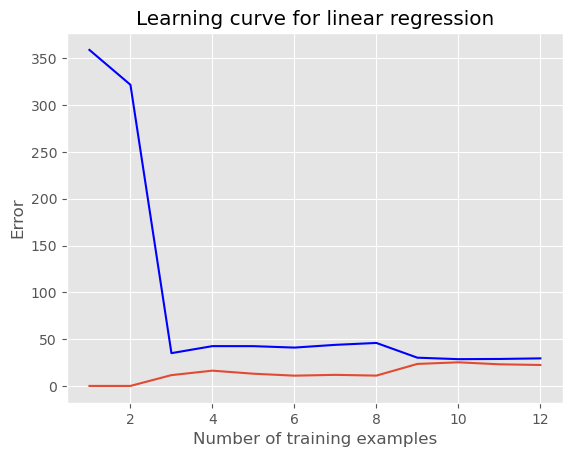

In [49]:
error_train, error_val = learningCurve(X, y)
num_train = list(range(1, len(error_train)+1))
plt.plot(num_train, error_train)
plt.plot(num_train, error_val, color='blue')
plt.xlabel('Number of training examples')
plt.ylabel('Error')
plt.title('Learning curve for linear regression')
plt.show()

## Polynomial Regression

The problem with our linear model was that it was too simple for the data and resulted in underfitting (high bias). In this part of the exercise, we address this problem by adding more features. For polynomial regression, our hypothesis has the form:

$$ h_\theta(x) = \theta_0 + \theta_1 \cdot (\text{waterLevel}) + \theta_2 \cdot (\text{waterLevel})^2 + \cdots + \theta_p \cdot (\text{waterLevel})^p $$

which can be simplified as:

$$ h_\theta(x) = \theta_0 + \theta_1 x_1 + \theta_2 x_2 + \cdots + \theta_p x_p $$

Notice that by defining $ x_1 = (\text{waterLevel}) $, $ x_2 = (\text{waterLevel})^2 $, ..., $ x_p = (\text{waterLevel})^p $, we obtain a linear regression model where the features are the various powers of the original value (waterLevel).

Now, you will add more features using the higher powers of the existing feature $ x $ in the dataset. The function `polyFeatures`  maps the original training set $ X $ of size $ m \times 1 $ into its higher powers. Specifically, when a training set $ X $ of size $ m \times 1 $ is passed into the function, the function returns a $ m \times p $ matrix $ X_{\text{poly}} $, where:

- Column 1 holds the original values of $ X $,
- Column 2 holds the values of $ X^2 $,
- Column 3 holds the values of $ X^3 $, and so on.

Note that we don’t have to account for the zeroth power in this function.

Now you have a function that will map features to a higher dimension, and Part 6 of `ex5.m` will apply it to the training set, the test set, and the cross-validation set (which you haven’t used yet).